In [14]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [15]:
# 1. Load data
df = pd.read_csv("movies_cleaned.csv")

# ...existing code...

# 2. Gán nhãn phân loại dựa trên rating (training labels)
def label_rating(r):
    if r < 5:
        return "Low"
    elif r < 7:
        return "Medium"
    else:
        return "High"

df["rating_label"] = df["averageRating"].apply(label_rating)

# 3. Tạo features cho việc học phân loại
# Loại bỏ averageRating khỏi features vì đó là target leak
X = df[["runtimeMinutes", "numVotes", "genres", "startYear"]]  # Thêm startYear
y = df["rating_label"]

# Feature engineering
X["logVotes"] = np.log1p(X["numVotes"])
X = X.drop(columns=["numVotes"])

# Xử lý startYear nếu có missing values
X["startYear"] = pd.to_numeric(X["startYear"], errors='coerce')
X["startYear"] = X["startYear"].fillna(X["startYear"].median())

# 4. Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 5. Enhanced preprocessing
numeric_features = ["runtimeMinutes", "logVotes", "startYear"]
categorical_features = ["genres"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)

C:\Users\Ngo Xuan Vinh\AppData\Local\Temp\ipykernel_27036\1373685620.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["logVotes"] = np.log1p(X["numVotes"])


In [16]:
# 6. Logistic Regression Pipeline
log_reg_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# 7. Train & Evaluate Logistic Regression
print("=== Logistic Regression ===")
log_reg_pipeline.fit(X_train, y_train)
y_pred_lr = log_reg_pipeline.predict(X_val)
print(classification_report(y_val, y_pred_lr))
print(confusion_matrix(y_val, y_pred_lr))


=== Logistic Regression ===
              precision    recall  f1-score   support

        High       0.57      0.36      0.44        56
         Low       0.46      0.18      0.26        34
      Medium       0.60      0.83      0.70       112

    accuracy                           0.59       202
   macro avg       0.55      0.45      0.46       202
weighted avg       0.57      0.59      0.55       202

[[20  2 34]
 [ 1  6 27]
 [14  5 93]]


In [17]:
# 8. Random Forest Pipeline
rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

# 9. Train & Evaluate Random Forest
print("\n=== Random Forest ===")
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))



=== Random Forest ===
              precision    recall  f1-score   support

        High       0.47      0.29      0.36        56
         Low       0.33      0.11      0.17        35
      Medium       0.58      0.81      0.68       112

    accuracy                           0.55       203
   macro avg       0.46      0.40      0.40       203
weighted avg       0.51      0.55      0.50       203

[[16  3 37]
 [ 2  4 29]
 [16  5 91]]


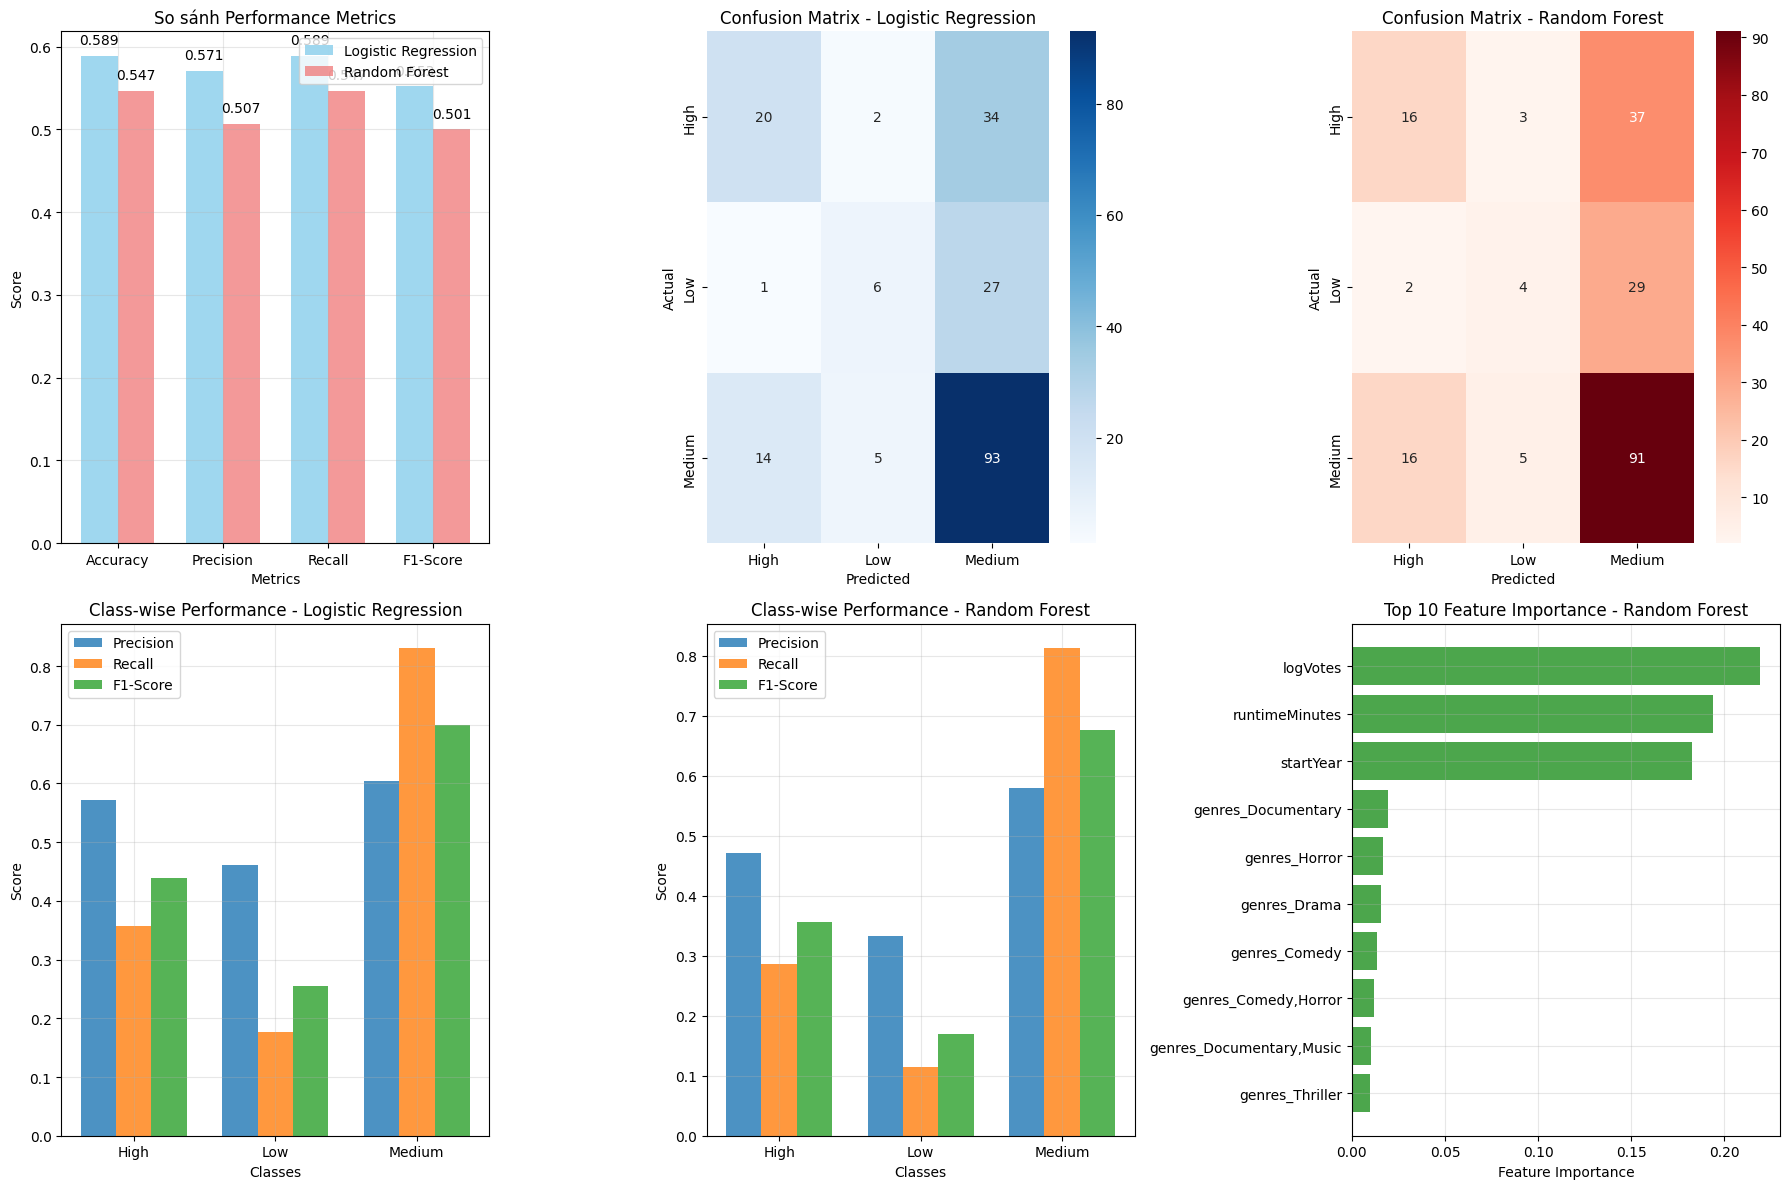


BẢNG SO SÁNH CHI TIẾT
              Metric Logistic Regression Random Forest
            Accuracy              0.5891        0.5468
Precision (Weighted)              0.5709        0.5071
   Recall (Weighted)              0.5891        0.5468
 F1-Score (Weighted)              0.5525        0.5007

KẾT LUẬN:
✓ Logistic Regression có accuracy cao hơn: 0.5891 vs 0.5468
✓ Logistic Regression có F1-score cao hơn: 0.5525 vs 0.5007


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# 10. Trực quan hóa kết quả so sánh hai mô hình
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Tính toán metrics cho cả hai mô hình
# Logistic Regression (sử dụng validation set)
lr_accuracy = accuracy_score(y_val, y_pred_lr)
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(y_val, y_pred_lr, average='weighted')

# Random Forest (sử dụng test set)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')

# 1. So sánh metrics tổng quan
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
lr_scores = [lr_accuracy, lr_precision, lr_recall, lr_f1]
rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1]

x = np.arange(len(metrics))
width = 0.35

axes[0, 0].bar(x - width/2, lr_scores, width, label='Logistic Regression', alpha=0.8, color='skyblue')
axes[0, 0].bar(x + width/2, rf_scores, width, label='Random Forest', alpha=0.8, color='lightcoral')
axes[0, 0].set_xlabel('Metrics')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('So sánh Performance Metrics')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Thêm giá trị trên cột
for i, (lr_score, rf_score) in enumerate(zip(lr_scores, rf_scores)):
    axes[0, 0].text(i - width/2, lr_score + 0.01, f'{lr_score:.3f}', ha='center', va='bottom')
    axes[0, 0].text(i + width/2, rf_score + 0.01, f'{rf_score:.3f}', ha='center', va='bottom')

# 2. Confusion Matrix cho Logistic Regression
cm_lr = confusion_matrix(y_val, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['High', 'Low', 'Medium'], 
            yticklabels=['High', 'Low', 'Medium'], ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - Logistic Regression')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# 3. Confusion Matrix cho Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds',
            xticklabels=['High', 'Low', 'Medium'], 
            yticklabels=['High', 'Low', 'Medium'], ax=axes[0, 2])
axes[0, 2].set_title('Confusion Matrix - Random Forest')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# 4. Class-wise Performance cho Logistic Regression
lr_class_report = classification_report(y_val, y_pred_lr, output_dict=True)
classes = ['High', 'Low', 'Medium']
lr_class_f1 = [lr_class_report[cls]['f1-score'] for cls in classes]
lr_class_precision = [lr_class_report[cls]['precision'] for cls in classes]
lr_class_recall = [lr_class_report[cls]['recall'] for cls in classes]

x_classes = np.arange(len(classes))
width = 0.25

axes[1, 0].bar(x_classes - width, lr_class_precision, width, label='Precision', alpha=0.8)
axes[1, 0].bar(x_classes, lr_class_recall, width, label='Recall', alpha=0.8)
axes[1, 0].bar(x_classes + width, lr_class_f1, width, label='F1-Score', alpha=0.8)
axes[1, 0].set_xlabel('Classes')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Class-wise Performance - Logistic Regression')
axes[1, 0].set_xticks(x_classes)
axes[1, 0].set_xticklabels(classes)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Class-wise Performance cho Random Forest
rf_class_report = classification_report(y_test, y_pred_rf, output_dict=True)
rf_class_f1 = [rf_class_report[cls]['f1-score'] for cls in classes]
rf_class_precision = [rf_class_report[cls]['precision'] for cls in classes]
rf_class_recall = [rf_class_report[cls]['recall'] for cls in classes]

axes[1, 1].bar(x_classes - width, rf_class_precision, width, label='Precision', alpha=0.8)
axes[1, 1].bar(x_classes, rf_class_recall, width, label='Recall', alpha=0.8)
axes[1, 1].bar(x_classes + width, rf_class_f1, width, label='F1-Score', alpha=0.8)
axes[1, 1].set_xlabel('Classes')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Class-wise Performance - Random Forest')
axes[1, 1].set_xticks(x_classes)
axes[1, 1].set_xticklabels(classes)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. So sánh Feature Importance (chỉ cho Random Forest)
# Lấy feature names sau khi preprocessing
feature_names = (numeric_features + 
                list(rf_pipeline.named_steps['preprocess']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features)))

importance = rf_pipeline.named_steps['classifier'].feature_importances_
top_indices = np.argsort(importance)[-10:]  # Top 10 features
top_features = [feature_names[i] for i in top_indices]
top_importance = importance[top_indices]

axes[1, 2].barh(range(len(top_features)), top_importance, color='green', alpha=0.7)
axes[1, 2].set_yticks(range(len(top_features)))
axes[1, 2].set_yticklabels(top_features)
axes[1, 2].set_xlabel('Feature Importance')
axes[1, 2].set_title('Top 10 Feature Importance - Random Forest')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Tạo bảng so sánh chi tiết
print("\n" + "="*60)
print("BẢNG SO SÁNH CHI TIẾT")
print("="*60)
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
    'Logistic Regression': [f'{lr_accuracy:.4f}', f'{lr_precision:.4f}', f'{lr_recall:.4f}', f'{lr_f1:.4f}'],
    'Random Forest': [f'{rf_accuracy:.4f}', f'{rf_precision:.4f}', f'{rf_recall:.4f}', f'{rf_f1:.4f}']
})
print(comparison_df.to_string(index=False))

print(f"\n{'='*60}")
print("KẾT LUẬN:")
print(f"{'='*60}")
if rf_accuracy > lr_accuracy:
    print(f"✓ Random Forest có accuracy cao hơn: {rf_accuracy:.4f} vs {lr_accuracy:.4f}")
else:
    print(f"✓ Logistic Regression có accuracy cao hơn: {lr_accuracy:.4f} vs {rf_accuracy:.4f}")

if rf_f1 > lr_f1:
    print(f"✓ Random Forest có F1-score cao hơn: {rf_f1:.4f} vs {lr_f1:.4f}")
else:
    print(f"✓ Logistic Regression có F1-score cao hơn: {lr_f1:.4f} vs {rf_f1:.4f}")